In [1]:
import gmsh

gmsh.initialize()

# meshsize settings
meshsize = 0.02
gmsh.option.setNumber("Mesh.MeshSizeMax", meshsize)
gmsh.option.setNumber("Mesh.MeshSizeMax", meshsize)


# create geometry
L = 1
W = 0.1

gmsh.model.occ.addBox(0, 0, 0, L, W, W)
gmsh.model.occ.synchronize()

# setup physical groups
v_bc_tag = 2
Z_bc_tag = 3
gmsh.model.addPhysicalGroup(3, [1], 1, "air_volume")
gmsh.model.addPhysicalGroup(2, [1], v_bc_tag, "velocity_BC")
gmsh.model.addPhysicalGroup(2, [2], Z_bc_tag, "impedance")

# mesh generation
gmsh.model.mesh.generate(3)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000660784s, CPU 0.000841s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0247899s

Then we import the gmsh mesh with the ```dolfinx.io.gmshio``` function.

In [2]:
from mpi4py import MPI
from dolfinx import (
    fem,
    io,
    default_scalar_type,
    geometry,
    __version__ as dolfinx_version,
)
from dolfinx.fem.petsc import LinearProblem
import ufl
import numpy as np
import numpy.typing as npt
from packaging.version import Version

mesh_data = io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=3)
if Version(dolfinx_version) > Version("0.9.0"):
    domain = mesh_data.mesh
    assert mesh_data.facet_tags is not None
    facet_tags = mesh_data.facet_tags
else:
    domain, _, facet_tags = mesh_data


We define the function space for our unknown $p$ and define the range of frequencies we want to solve the Helmholtz equation for.

In [3]:
!echo $PYTHONPATH

/usr/local/dolfinx-complex/lib/python3.12/dist-packages:/usr/local/dolfinx-real/lib/python3.12/dist-packages:/usr/local/lib::/usr/bin/


In [4]:

V = fem.functionspace(domain, ("Lagrange", 1))

# Discrete frequency range
freq = np.arange(10, 1000, 1)  # Hz

# Air parameters
rho0 = 1.225  # kg/m^3
c = 340  # m/s


## Boundary conditions

The Delaney-Bazley model is used to compute the characteristic impedance and wavenumber of the porous layer,
treated as an equivalent fluid with complex valued properties

$$
\begin{align}
Z_c(\omega) &= \rho_0 c_0 \left[1 + 0.0571 X^{-0.754} - j 0.087 X^{-0.732}\right],\\
k_c(\omega) &= \frac{\omega}{c_0} \left[1 + 0.0978 X^{-0.700} - j 0.189 X^{-0.595}\right],\\
\end{align}
$$

where $X = \frac{\rho_0 f}{\sigma}$.

With these, we can compute the surface impedance, that in the case of a rigid passive absorber placed on a rigid wall is given by the formula
$$
\begin{align}
Z_s = -j Z_c cot(k_c d).
\end{align}
$$

Let's create a function to compute it.



In [5]:
# Impedance calculation
def delany_bazley_layer(f, rho0, c, sigma):
    X = rho0 * f / sigma
    Zc = rho0 * c * (1 + 0.0571 * X**-0.754 - 1j * 0.087 * X**-0.732)
    kc = 2 * np.pi * f / c * (1 + 0.0978 * (X**-0.700) - 1j * 0.189 * (X**-0.595))
    Z_s = -1j * Zc * (1 / np.tan(kc * d))
    return Z_s


sigma = 1.5e4
d = 0.01
Z_s = delany_bazley_layer(freq, rho0, c, sigma)

Since we are going to compute a sound pressure spectrum, all the variables that depend on frequency (that are $\omega$, $k$ and $Z$) need to be updated in the frequency loop.
To make this possible, we will initialize them as dolfinx constants.
Then, we define the value for the normal velocity on the first end of the tube

In [6]:
omega = fem.Constant(domain, default_scalar_type(0))
k = fem.Constant(domain, default_scalar_type(0))
Z = fem.Constant(domain, default_scalar_type(0))
v_n = 1e-5

We also need to specify the integration measure $ds$, by using ```ufl```, and its built in integration measures

In [7]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

## Variational Formulation
We can now write the variational formulation.

In [8]:
p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = (
    ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx
    + 1j * rho0 * omega / Z * ufl.inner(p, v) * ds(Z_bc_tag)
    - k**2 * ufl.inner(p, v) * ufl.dx
)
L = -1j * omega * rho0 * ufl.inner(v_n, v) * ds(v_bc_tag)

The class ```LinearProblem``` is used to setup the PETSc backend and assemble the system vector and matrices.
The solution will be stored in a `dolfinx.fem.Function`, ```p_a```.

In [9]:
p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

## Computing the pressure at a given location
Before starting our frequency loop, we can build a function that, given a microphone position,
computes the sound pressure at its location.
We will use the a similar method as in [Deflection of a membrane](../chapter1/membrane_code).
However, as the domain doesn't deform in time, we cache the collision detection

In [10]:
class MicrophonePressure:
    def __init__(self, domain, microphone_position):
        """Initialize microphone(s).

        Args:
            domain: The domain to insert microphones on
            microphone_position: Position of the microphone(s).
                Assumed to be ordered as ``(mic0_x, mic1_x, ..., mic0_y, mic1_y, ..., mic0_z, mic1_z, ...)``

        """
        self._domain = domain
        self._position = np.asarray(
            microphone_position, dtype=domain.geometry.x.dtype
        ).reshape(3, -1)
        self._local_cells, self._local_position = self.compute_local_microphones()

    def compute_local_microphones(
        self,
    ) -> tuple[npt.NDArray[np.int32], npt.NDArray[np.floating]]:
        """
        Compute the local microphone positions for a distributed mesh

        Returns:
            Two lists (local_cells, local_points) containing the local cell indices and the local points
        """
        points = self._position.T
        bb_tree = geometry.bb_tree(self._domain, self._domain.topology.dim)

        cells = []
        points_on_proc = []

        cell_candidates = geometry.compute_collisions_points(bb_tree, points)
        colliding_cells = geometry.compute_colliding_cells(
            domain, cell_candidates, points
        )

        for i, point in enumerate(points):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])

        return np.asarray(cells, dtype=np.int32), np.asarray(
            points_on_proc, dtype=domain.geometry.x.dtype
        )

    def listen(
        self, recompute_collisions: bool = False
    ) -> npt.NDArray[np.complexfloating]:
        if recompute_collisions:
            self._local_cells, self._local_position = self.compute_local_microphones()
        if len(self._local_cells) > 0:
            return p_a.eval(self._local_position, self._local_cells)
        else:
            return np.zeros(0, dtype=default_scalar_type)

The pressure spectrum is initialized as a numpy array and the microphone location is assigned

In [11]:
p_mic = np.zeros((len(freq), 1), dtype=complex)

mic = np.array([0.5, 0.05, 0.05])
microphone = MicrophonePressure(domain, mic)

## Frequency loop

Finally, we can write the frequency loop, where we update the values of the frequency-dependent variables and solve the system for each frequency

In [12]:
for nf in range(0, len(freq)):
    k.value = 2 * np.pi * freq[nf] / c
    omega.value = 2 * np.pi * freq[nf]
    Z.value = Z_s[nf]

    problem.solve()
    p_a.x.scatter_forward()

    p_f = microphone.listen()
    p_f = domain.comm.gather(p_f, root=0)

    if domain.comm.rank == 0:
        assert p_f is not None
        p_mic[nf] = np.hstack(p_f)

## SPL spectrum
After the computation, the pressure spectrum at the prescribed location is available.
Such a spectrum is usually shown using the decibel (dB) scale to obtain the SPL, with the RMS pressure as input,
defined as $p_{rms} = \frac{p}{\sqrt{2}}$.

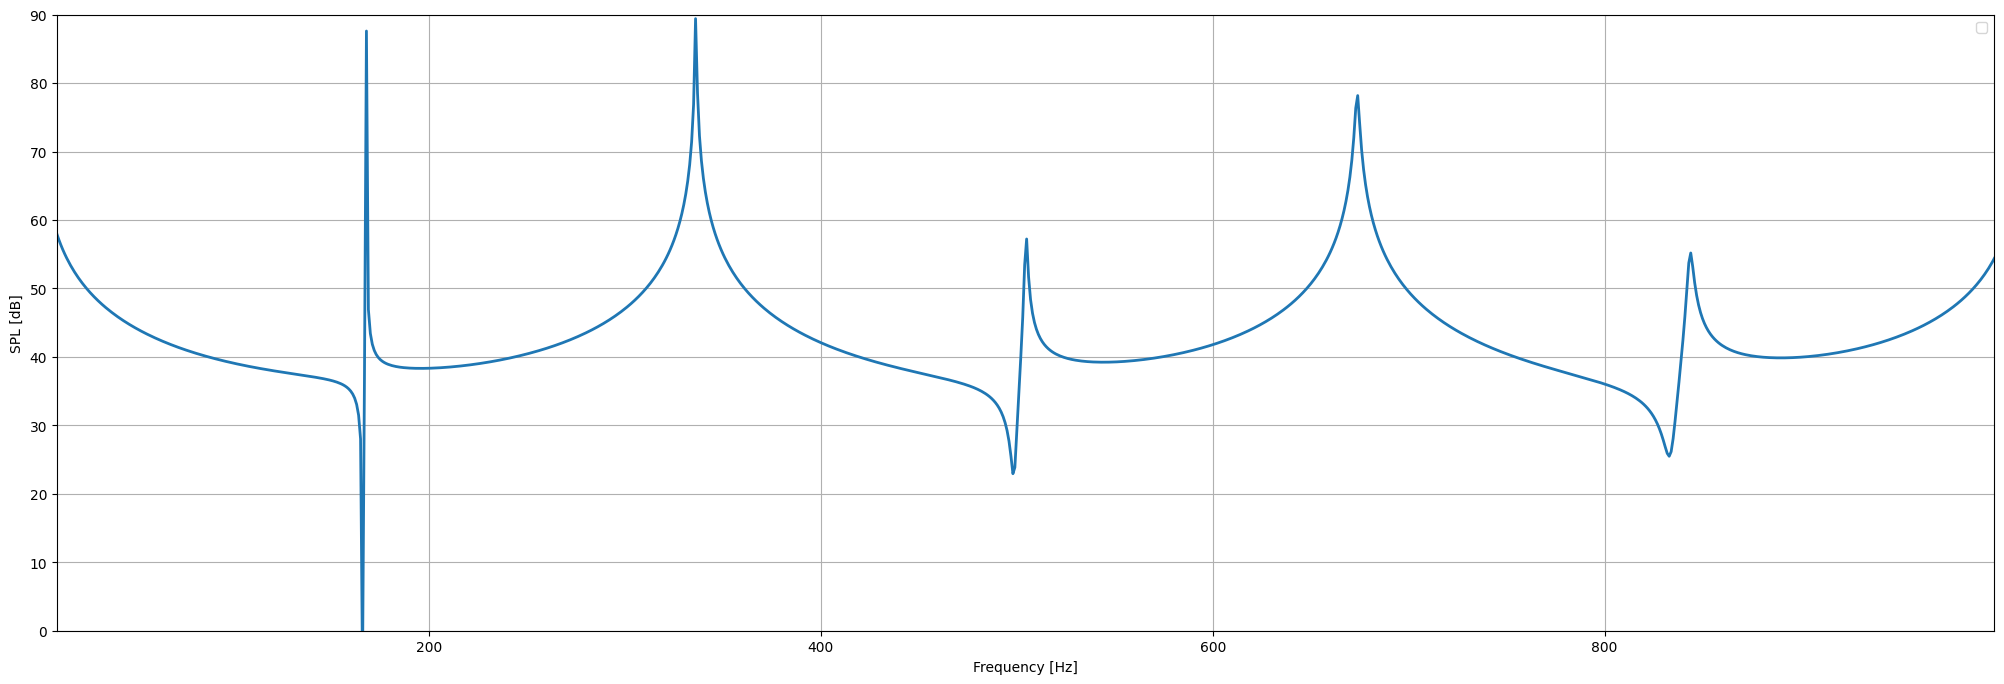

In [13]:
if domain.comm.rank == 0:
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(25, 8))
    plt.plot(freq, 20 * np.log10(np.abs(p_mic) / np.sqrt(2) / 2e-5), linewidth=2)
    plt.grid(True)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("SPL [dB]")
    plt.xlim([freq[0], freq[-1]])
    plt.ylim([0, 90])
    plt.legend()
    plt.show()

In [14]:
!echo $PYTHONPATH

/usr/local/dolfinx-complex/lib/python3.12/dist-packages:/usr/local/dolfinx-real/lib/python3.12/dist-packages:/usr/local/lib::/usr/bin/
